# Crypto Portfolio Selection 

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import polars as pl
import polars.selectors as cs

# Load data

In [2]:
import pandas as pd
import yfinance as yf

data: pd.DataFrame = yf.download("BTC-USD ETH-USD", start="2022-01-01", end="2024-01-01")["Close"].dropna()

[*********************100%***********************]  2 of 2 completed


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

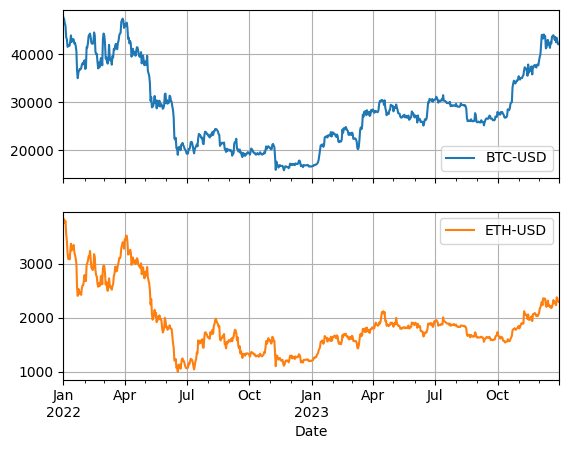

In [3]:
data.plot(grid=True, subplots=True)

In [4]:
pl.from_dataframe(data.reset_index()) 

Date,BTC-USD,ETH-USD
"datetime[ns, UTC]",f64,f64
2022-01-01 00:00:00 UTC,47686.8125,3769.697021
2022-01-02 00:00:00 UTC,47345.21875,3829.564941
2022-01-03 00:00:00 UTC,46458.117188,3761.380371
2022-01-04 00:00:00 UTC,45897.574219,3794.056641
2022-01-05 00:00:00 UTC,43569.003906,3550.386963
…,…,…
2023-12-27 00:00:00 UTC,43442.855469,2378.73999
2023-12-28 00:00:00 UTC,42627.855469,2347.566162
2023-12-29 00:00:00 UTC,42099.402344,2300.690674


In [5]:
df_returns = (
    pl.from_dataframe(data.reset_index()) 
    .select(
        cs.datetime(),
        pl.col("BTC-USD").pct_change(),
        pl.col("ETH-USD").pct_change(),
    )
    .drop_nulls()
)
df_returns

Date,BTC-USD,ETH-USD
"datetime[ns, UTC]",f64,f64
2022-01-02 00:00:00 UTC,-0.007163,0.015881
2022-01-03 00:00:00 UTC,-0.018737,-0.017805
2022-01-04 00:00:00 UTC,-0.012066,0.008687
2022-01-05 00:00:00 UTC,-0.050734,-0.064224
2022-01-06 00:00:00 UTC,-0.009366,-0.037173
…,…,…
2023-12-27 00:00:00 UTC,0.021694,0.065999
2023-12-28 00:00:00 UTC,-0.01876,-0.013105
2023-12-29 00:00:00 UTC,-0.012397,-0.019968


# Offline portfolio

In [6]:
from potato.benchmark import best_kelly_portfolio


returns = jnp.array(
    df_returns.to_numpy()[:, 1:]
)

long_only = best_kelly_portfolio(returns)
long_short = best_kelly_portfolio(returns, short_selling=True)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [7]:
df_portfolio_return = (
    df_returns
    .with_columns(
        CRP = pl.col(df_returns.columns[1]) * (0.5) + pl.col(df_returns.columns[2]) * 0.5,
        kelly_long_only = pl.col(df_returns.columns[1]) * long_only[0] + pl.col(df_returns.columns[2]) * long_only[1],
        kelly_long_short = pl.col(df_returns.columns[1]) * long_short[0] + pl.col(df_returns.columns[2]) * long_short[1],
    )
)

optimal fixed porfolio

In [8]:
long_short

Array([ 0.6204711, -0.3795289], dtype=float32)

# Online portfolio

## Long/short portfolio

In [9]:
import optax
from potato.optimizer import proj_gd
from potato.projection import projection_l1_ball
from potato.loss import kelly_loss

lr = 1.5
optimizer = proj_gd(lr, projection_l1_ball)
opt_state = optimizer.init(returns[0])

In [10]:
@jax.jit
def step(params, rs, state):
    loss, grad = jax.value_and_grad(kelly_loss)(params, rs)
    updates, state = optimizer.update(grad, state, params)
    params = optax.apply_updates(params, updates)
    return params, state, loss

params = jnp.array([0.0, 0.0])
weights = []
for i in range(returns.shape[0]):
    weights.append(params)
    params, opt_state, loss = step(params, returns[i], opt_state)
    # print(f"Step {i}: loss={loss}, params={params}")

weights = np.array(weights)

In [11]:
df_portfolio_return = df_portfolio_return.with_columns(
    PGD=pl.Series(values=np.sum(weights * np.array(returns), axis=-1))
)

In [12]:
df_sharpes = (
    df_portfolio_return
    .select(cs.numeric().mean() / cs.numeric().std() * jnp.sqrt(252))
)
df_sharpes

BTC-USD,ETH-USD,CRP,kelly_long_only,kelly_long_short,PGD
f64,f64,f64,f64,f64,f32
0.136443,-0.01001,0.056296,0.136443,0.289368,0.120378


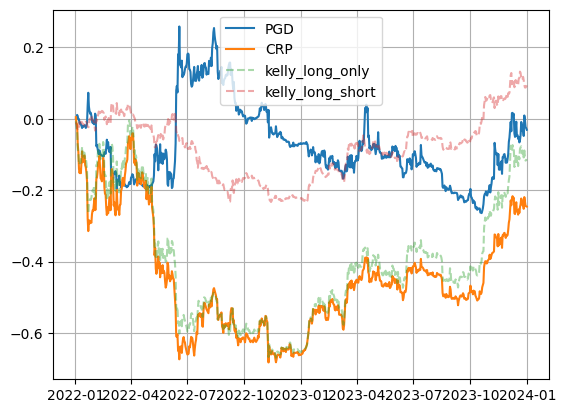

In [13]:
df_portfolio_return = (
    df_portfolio_return
    .select(cs.datetime(), cs.numeric().add(1).cum_prod().sub(1))
)

import matplotlib.pyplot as plt

plt.plot(df_returns["Date"], df_portfolio_return["PGD"], label="PGD")
plt.plot(df_returns["Date"], df_portfolio_return["CRP"], label="CRP")
plt.plot(df_returns["Date"], df_portfolio_return["kelly_long_only"], label="kelly_long_only", linestyle="--", alpha=0.4)
plt.plot(df_returns["Date"], df_portfolio_return["kelly_long_short"], label="kelly_long_short", linestyle="--", alpha=0.4)
# plt.plot(df_returns["Date"], df_portfolio_return["BTC-USD"], label="BTC-USD", linestyle="--", alpha=0.5)
# plt.plot(df_returns["Date"], df_portfolio_return["ETH-USD"], label="ETH-USD", linestyle="--", alpha=0.5)
plt.legend()
plt.grid()
plt.show()

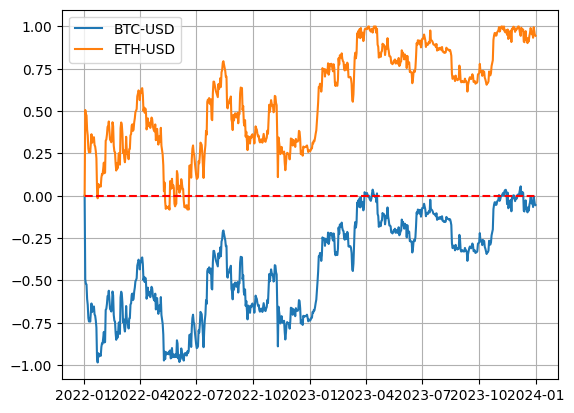

In [14]:
import matplotlib.pyplot as plt

plt.plot(df_returns["Date"], weights[:, 0], label="BTC-USD")
plt.plot(df_returns["Date"], weights[:, 1], label="ETH-USD")
plt.hlines(0, df_returns["Date"][0], df_returns["Date"][-1], linestyles="--", colors="red")
plt.legend()
plt.grid()
plt.show()

In [15]:
weights[:, 0]

array([ 0.        , -0.49346143, -0.52086145, -0.52336895, -0.60993886,
       -0.6451527 , -0.7223715 , -0.7432199 , -0.72411555, -0.74355966,
       -0.6892661 , -0.6365505 , -0.68697053, -0.6637216 , -0.6577232 ,
       -0.6542453 , -0.7003441 , -0.7094559 , -0.73667794, -0.7782902 ,
       -0.9582565 , -0.9850923 , -0.93031925, -0.95077896, -0.939776  ,
       -0.93815476, -0.94608235, -0.8939096 , -0.87202775, -0.8745092 ,
       -0.838569  , -0.80454844, -0.86671895, -0.86364377, -0.67451316,
       -0.6678134 , -0.6392684 , -0.59263384, -0.5926155 , -0.56119055,
       -0.6124001 , -0.66905093, -0.6745014 , -0.68407893, -0.664132  ,
       -0.5658451 , -0.5884253 , -0.70435214, -0.738691  , -0.7429287 ,
       -0.8099283 , -0.85102594, -0.80638057, -0.8391059 , -0.81550163,
       -0.74974096, -0.7473386 , -0.81622255, -0.60103434, -0.566875  ,
       -0.5797692 , -0.6341493 , -0.7477643 , -0.72905445, -0.7782776 ,
       -0.80202067, -0.7647041 , -0.6516576 , -0.7287292 , -0.75